In [2]:
import numpy as np
import pandas as pd
import pickle

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

import umap
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from bertopic import BERTopic

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline


In [4]:
vector_files = {
    "TF-IDF": "../data/interim/tfidf_vectorized.pkl",
    "Word2Vec": "../data/interim/word2vec_vectorized.pkl",
    "BERT": "../data/interim/bert_vectorized.pkl",
}

vectorized_data = {}

for name, path in vector_files.items():
    with open(path, "rb") as f:
        data = pickle.load(f)
        if isinstance(data, list):
            data = np.array(data)
        vectorized_data[name] = data

df_reviews = pd.read_csv("../data/processed/processed_reviews.csv")

print(f"TF-IDF Shape: {vectorized_data['TF-IDF'].shape}")
print(f"Word2Vec Shape: {vectorized_data['Word2Vec'].shape}")
print(f"BERT Shape: {vectorized_data['BERT'].shape}")
print("\nSample Reviews:\n", df_reviews[["rating", "lemmatized_text"]].head())

TF-IDF Shape: (2560, 1319)
Word2Vec Shape: (2560, 100)
BERT Shape: (2560, 768)

Sample Reviews:
    rating                                    lemmatized_text
0       1  ['often', 'last', 'first', 'purchase', 'luggag...
1       1  ['regard', 'booking', 'accommodation', 'regard...
2       1  ['sky', 'sky', 'staff', 'amount', 'without', '...
3       1  ['I', 've', 'always', 'shock', 'first', 'check...
4       1  ['family', 'ruin', 'arrive', 'check', 'counter...


In [5]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel

# Prepare corpus and dictionary
tfidf_corpus = [doc.split() for doc in df_reviews["lemmatized_text"]]
tfidf_dictionary = Dictionary(tfidf_corpus)
tfidf_bow = [tfidf_dictionary.doc2bow(doc) for doc in tfidf_corpus]

# Create TF-IDF model and transform BoW
tfidf_model = TfidfModel(tfidf_bow)
tfidf_weights = [tfidf_model[doc] for doc in tfidf_bow]

# Train final LDA using TF-IDF
lda_model = LdaModel(
    corpus=tfidf_weights,
    id2word=tfidf_dictionary,
    num_topics=8,
    passes=15,
    random_state=42,
)


In [6]:
from gensim.models.coherencemodel import CoherenceModel

coherence_scores = []
for k in range(2, 10):
    model = LdaModel(
        corpus=tfidf_bow, id2word=tfidf_dictionary, num_topics=k, passes=10
    )
    coherence_model = CoherenceModel(
        model=model, texts=tfidf_corpus, dictionary=tfidf_dictionary, coherence="c_v"
    )
    coherence_scores.append((k, coherence_model.get_coherence()))

# Find the best number of topics
best_k = max(coherence_scores, key=lambda x: x[1])[0]
print(f"Optimal number of topics: {best_k}")


Optimal number of topics: 2


In [7]:
# Evaluate coherence of the final LDA model (TF-IDF)
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=tfidf_corpus, dictionary=tfidf_dictionary, coherence="c_v"
)
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}")

Coherence Score: 0.6292855384233451


In [8]:
topics = lda_model.print_topics(num_words=10)

for topic in topics:
    print(topic)

# Create the directory if it doesn't exist
model_dir = "../models/lda_tfidf_model/"
os.makedirs(model_dir, exist_ok=True)

# Save the LDA model
lda_model.save(os.path.join(model_dir, "lda_tfidf_model"))

(0, '0.017*"\'clean\']" + 0.011*"[\'efficient\'," + 0.010*"\'lounge\']" + 0.009*"[\'flat\'," + 0.009*"[\'arrive\'," + 0.009*"[\'expensive\'," + 0.008*"\'movie\'," + 0.008*"\'emirate\']" + 0.008*"\'food\']" + 0.008*"[\'smooth\',"')
(1, '0.023*"[\'food\'," + 0.013*"\'always\']" + 0.012*"\'snack\']" + 0.011*"\'movie\'," + 0.011*"\'staff\'," + 0.011*"\'transfer\']" + 0.008*"\'english\']" + 0.008*"\'leg\'," + 0.008*"[\'cold\'," + 0.007*"\'worth\']"')
(2, '0.015*"[\'always\'," + 0.014*"[\'staff\'," + 0.012*"\'food\'," + 0.012*"\'staff\']" + 0.011*"\'quickly\']" + 0.011*"\'stroller\'," + 0.011*"[\'cost\'," + 0.011*"\'luggage\']" + 0.011*"\'okay\'," + 0.010*"\'something\']"')
(3, '0.011*"\'booking\'," + 0.010*"\'check\'," + 0.008*"\'transfer\'," + 0.008*"\'staff\'," + 0.008*"\'accommodation\'," + 0.007*"\'delayed\'," + 0.007*"\'arrive\'," + 0.007*"\'queue\'," + 0.006*"\'luggage\'," + 0.006*"\'boarding\',"')
(4, '0.014*"\'luggage\'," + 0.014*"\'bag\'," + 0.011*"\'check\'," + 0.010*"\'booking\',

In [9]:
# Assign LDA cluster labels to DataFrame
lda_labels = [
    max(lda_model[doc], key=lambda x: x[1])[0] for doc in tfidf_weights
]  # Assign most probable topic
df_reviews["lda_labels"] = lda_labels  # Save the LDA labels to the DataFrame

# Save the original DataFrame with LDA cluster labels to the cluster_analysis folder
df_reviews.to_csv(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/processed/cluster_analysis/reviews_with_lda_clusters.csv",
    index=False,
)


In [10]:
# Compute multiple coherence scores
coherence_types = ["c_v", "u_mass", "c_uci", "c_npmi"]
coherence_scores = {}

for coherence_type in coherence_types:
    model = CoherenceModel(
        model=lda_model,
        texts=tfidf_corpus,
        dictionary=tfidf_dictionary,
        coherence=coherence_type,
    )
    coherence_scores[coherence_type] = model.get_coherence()

# Display results
for metric, score in coherence_scores.items():
    print(f"{metric} Coherence Score: {score:.4f}")


c_v Coherence Score: 0.6293
u_mass Coherence Score: -10.6264
c_uci Coherence Score: -5.8057
c_npmi Coherence Score: -0.1891


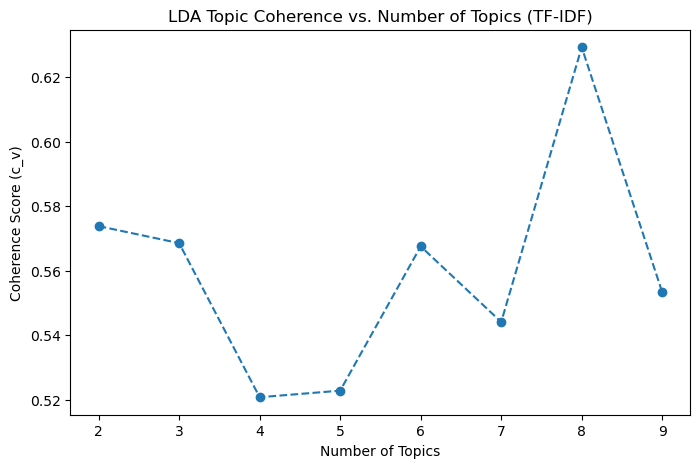

In [11]:
import matplotlib.pyplot as plt

topic_range = range(2, 10)
coherence_values = []

for num in topic_range:
    lda_temp = LdaModel(
        corpus=tfidf_weights,  # ✅ Use TF-IDF here!
        id2word=tfidf_dictionary,  # ✅ FIXED: added comma here
        num_topics=num,
        passes=15,
        random_state=42,
    )
    model = CoherenceModel(
        model=lda_temp,
        texts=tfidf_corpus,
        dictionary=tfidf_dictionary,
        coherence="c_v",
    )
    coherence_values.append(model.get_coherence())

# Plot the coherence scores
plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_values, marker="o", linestyle="--")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("LDA Topic Coherence vs. Number of Topics (TF-IDF)")
plt.show()


In [12]:
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda_model, tfidf_bow, tfidf_dictionary)

pyLDAvis.display(lda_display)

In [13]:
from gensim.models import Phrases

# Train bigram model to find common multi-word phrases
bigram = Phrases(tfidf_corpus, min_count=5, threshold=10)
tfidf_corpus_bigrams = [bigram[doc] for doc in tfidf_corpus]

# Re-train LDA with bigrams
lda_model_bigrams = LdaModel(
    corpus=[tfidf_dictionary.doc2bow(doc) for doc in tfidf_corpus_bigrams],
    id2word=tfidf_dictionary,
    num_topics=8,
    passes=15,
    random_state=42,
)

# Display pyLDAvis for bigram-enhanced LDA
lda_display_bigrams = gensimvis.prepare(lda_model_bigrams, tfidf_bow, tfidf_dictionary)
pyLDAvis.display(lda_display_bigrams)


In [14]:
# Convert documents to BOW format
corpus_bigrams = [tfidf_dictionary.doc2bow(doc) for doc in tfidf_corpus_bigrams]

# Get topic distribution per document
lda_topic_distribution = [
    lda_model_bigrams.get_document_topics(doc, minimum_probability=0)
    for doc in corpus_bigrams
]

# Convert to DataFrame
import pandas as pd

topic_distribution_df = pd.DataFrame(
    [{f"Topic_{i}": prob for i, prob in dist} for dist in lda_topic_distribution]
)

# Save and display
topic_distribution_df.to_csv(
    "../data/processed/lda_topic_distribution.csv", index=False
)
topic_distribution_df.head()


Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
0  0.424341  0.002088  0.002087  0.002087  0.489950  0.002089  0.002086   
1  0.006262  0.324605  0.364884  0.006266  0.279189  0.006264  0.006274   
2  0.057986  0.003913  0.218178  0.348227  0.235358  0.003911  0.003911   
3  0.002983  0.090750  0.002980  0.002981  0.265277  0.002982  0.002978   
4  0.002088  0.305225  0.002087  0.592163  0.002088  0.092175  0.002086   

    Topic_7  
0  0.075273  
1  0.006257  
2  0.128516  
3  0.629070  
4  0.002088

In [15]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Coherence Score for LDA with bigrams
coherence_model_lda_bigrams = CoherenceModel(
    model=lda_model_bigrams,  # The new bigram-enhanced LDA model
    texts=tfidf_corpus_bigrams,  # Bigrams-based corpus
    dictionary=tfidf_dictionary,
    coherence="c_v",  # c_v coherence is commonly used for LDA
)

coherence_lda_bigrams = coherence_model_lda_bigrams.get_coherence()
print(f"\nLDA Bigrams Coherence Score: {coherence_lda_bigrams:.4f}")



LDA Bigrams Coherence Score: 0.5494


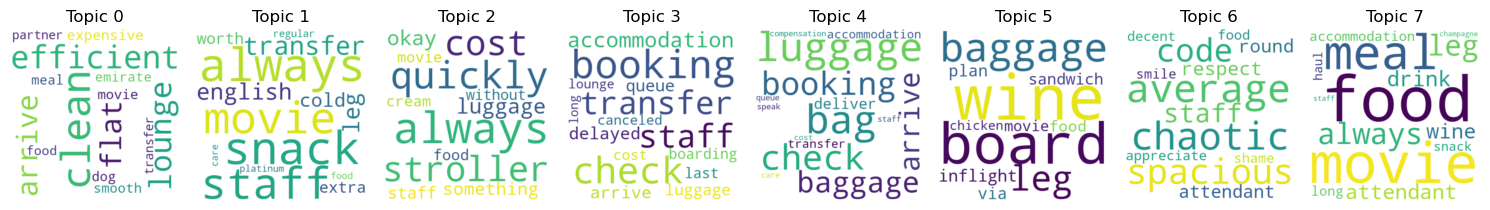

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Extract top words and their weights as dictionaries
top_words_per_topic = []
for topic_id in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(topic_id, topn=15)
    clean_terms = {word.strip("'\"[]():,"): weight for word, weight in topic_terms}
    top_words_per_topic.append(clean_terms)

# Plot word clouds for each topic
fig, axes = plt.subplots(1, lda_model.num_topics, figsize=(15, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    wordcloud = WordCloud(width=400, height=400, background_color="white")
    wordcloud.generate_from_frequencies(top_words_per_topic[i])
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"Topic {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()


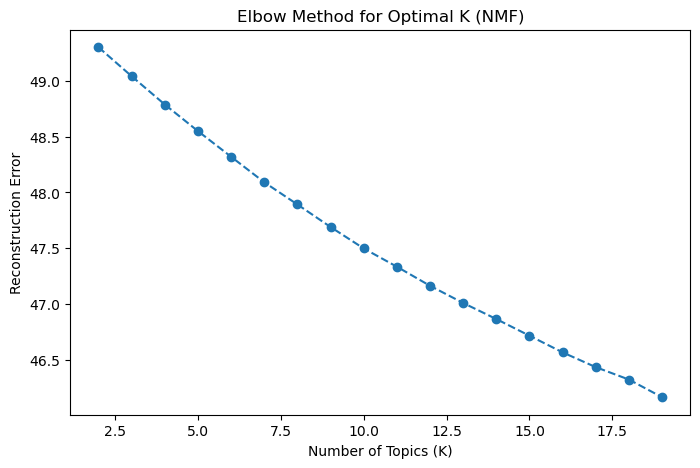

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

# Define range of topics to test
k_values = list(range(2, 20))  # Try K from 2 to 20
errors = []

for k in k_values:
    nmf_model = NMF(n_components=k, random_state=42)
    W = nmf_model.fit_transform(vectorized_data["TF-IDF"])  # Factorize
    H = nmf_model.components_
    reconstruction_error = np.linalg.norm(
        vectorized_data["TF-IDF"] - np.dot(W, H)
    )  # Compute error
    errors.append(reconstruction_error)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, marker="o", linestyle="--")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Reconstruction Error")
plt.title("Elbow Method for Optimal K (NMF)")
plt.show()


In [18]:
# Set number of topics
num_topics = 8

# Fit NMF Model
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_topics = nmf_model.fit_transform(vectorized_data["TF-IDF"])

# Extract Feature Names Properly
tfidf_feature_names = vectorized_data["TF-IDF"].columns

# Store Top Words per Topic
top_words_per_topic = []

for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [
        (tfidf_feature_names[i], topic[i])
        for i in topic.argsort()[-10:]  # Includes weights
    ]
    top_words_per_topic.append(top_words)

# Print Topics
for i, words in enumerate(top_words_per_topic):
    print(f"\nTopic {i}:")
    for word, weight in words:
        print(f"{word} ({weight:.4f})", end=", ")
    print("\n" + "-" * 40)


Topic 0:
carryon (0.2249), check check (0.2338), bag check (0.2530), people (0.2967), bag bag (0.3507), queue (0.5418), check bag (0.5855), baggage (0.6070), check (1.8559), bag (2.5288), 
----------------------------------------

Topic 1:
movie music (0.1198), music (0.1346), average (0.1483), watch (0.1814), food movie (0.1979), movie food (0.2569), movie movie (0.3751), inflight movie (0.3784), inflight (0.4356), movie (1.7310), 
----------------------------------------

Topic 2:
canceled booking (0.1654), agent (0.1735), email (0.1830), money (0.2647), booking booking (0.2988), transfer (0.3080), compensation (0.3983), cost (0.4938), canceled (0.5693), booking (1.6079), 
----------------------------------------

Topic 3:
staff staff (0.0847), staff check (0.0853), check (0.1117), professional (0.1301), staff professional (0.1337), ground staff (0.1391), food staff (0.1408), ground (0.1547), staff food (0.2061), staff (2.0515), 
----------------------------------------

Topic 4:
di

In [19]:
# Assign NMF cluster labels to DataFrame
nmf_labels = nmf_topics.argmax(axis=1)  # Get the most probable topic for each document
df_reviews["nmf_labels"] = nmf_labels  # Save the NMF labels to the DataFrame

# Save the DataFrame with NMF labels to the cluster_analysis folder
df_reviews.to_csv(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/processed/cluster_analysis/reviews_with_nmf_clusters.csv",
    index=False,
)


In [20]:
pickle.dump(nmf_model, open("../models/nmf_tfidf_model/nmf_tfidf_model.pkl", "wb"))

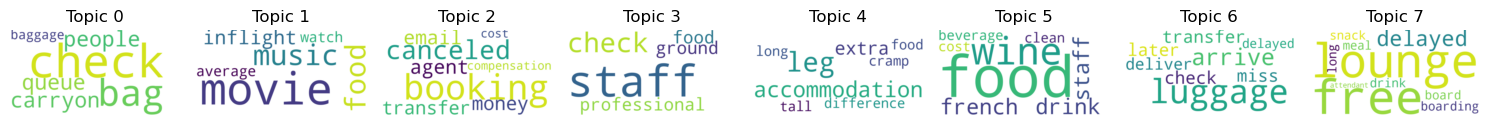

In [21]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Ensure top words are correctly extracted
top_words_per_topic = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [
        tfidf_feature_names[i] for i in topic.argsort()[-10:]
    ]  # Get top words correctly
    top_words_per_topic.append(top_words)  # Store as a list of words

# Plot word clouds
fig, axes = plt.subplots(1, 8, figsize=(15, 8))  # Adjust layout
axes = axes.flatten()

for i, topic_words in enumerate(top_words_per_topic):
    wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
        " ".join(topic_words)
    )  # Properly join words

    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].set_title(f"Topic {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


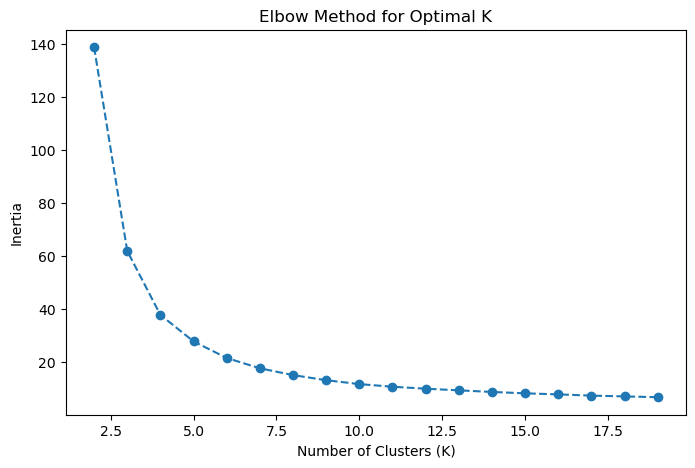

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try different values of K
num_clusters = list(range(2, 20))
inertia = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(vectorized_data["Word2Vec"])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(num_clusters, inertia, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


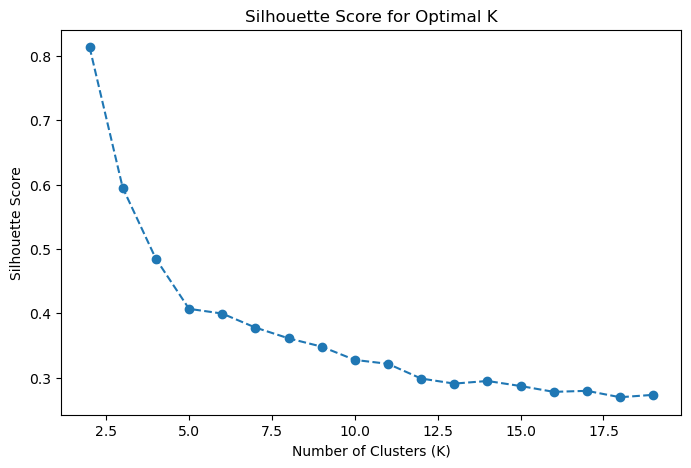

In [23]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(vectorized_data["Word2Vec"])
    score = silhouette_score(vectorized_data["Word2Vec"], labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(num_clusters, silhouette_scores, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal K")
plt.show()


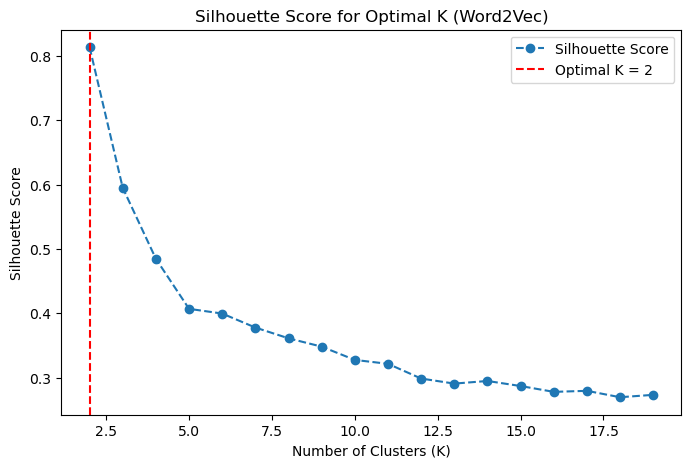

✅ Best K from Silhouette Score: 2


In [24]:
import numpy as np

# Find the optimal K (max silhouette score)
best_k_silhouette = num_clusters[np.argmax(silhouette_scores)]

# Plot Silhouette Scores with Optimal K
plt.figure(figsize=(8, 5))
plt.plot(
    num_clusters,
    silhouette_scores,
    marker="o",
    linestyle="--",
    label="Silhouette Score",
)
plt.axvline(
    best_k_silhouette,
    linestyle="--",
    color="red",
    label=f"Optimal K = {best_k_silhouette}",
)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal K (Word2Vec)")
plt.legend()
plt.show()

print(f"✅ Best K from Silhouette Score: {best_k_silhouette}")


In [25]:
from sklearn.cluster import KMeans

# Set number of topics (clusters)
num_topics = 5

# Fit KMeans model
kmeans_model = KMeans(n_clusters=num_topics, random_state=42, n_init=10)
word2vec_topics = kmeans_model.fit_predict(vectorized_data["Word2Vec"])

print(f"KMeans clustering applied with {num_topics} topics.")

KMeans clustering applied with 5 topics.


In [26]:
# Assign topic labels to dataframe
df_reviews["word2vec_topic"] = word2vec_topics

# Display sample reviews with assigned topics
df_reviews[["rating", "lemmatized_text", "word2vec_topic"]].head()


rating                                    lemmatized_text  word2vec_topic
0       1  ['often', 'last', 'first', 'purchase', 'luggag...               0
1       1  ['regard', 'booking', 'accommodation', 'regard...               0
2       1  ['sky', 'sky', 'staff', 'amount', 'without', '...               4
3       1  ['I', 've', 'always', 'shock', 'first', 'check...               0
4       1  ['family', 'ruin', 'arrive', 'check', 'counter...               4

In [27]:
from collections import Counter

# Convert string tokens to lists
df_reviews["lemmatized_text"] = df_reviews["lemmatized_text"].apply(eval)

# Group words by topics
topic_word_lists = {i: [] for i in range(num_topics)}
for tokens, topic in zip(df_reviews["lemmatized_text"], df_reviews["word2vec_topic"]):
    topic_word_lists[topic].extend(tokens)

# Get most common words per topic
top_words_per_topic = {
    i: [word for word, count in Counter(topic_word_lists[i]).most_common(10)]
    for i in range(num_topics)
}

# Display top words for each topic
for topic, words in top_words_per_topic.items():
    print(f"Topic {topic}: {', '.join(words)}")


Topic 0: booking, check, food, luggage, staff, bag, accommodation, arrive, movie, transfer
Topic 1: food, standard, rest, staff, second, delayed, negative, efficient, leg, via
Topic 2: food, staff, attendant, arrive, accommodation, clean, schedule, always, meal, smooth
Topic 3: food, staff, movie, check, cost, booking, long, accommodation, attendant, meal
Topic 4: food, check, booking, staff, movie, luggage, bag, cost, accommodation, meal


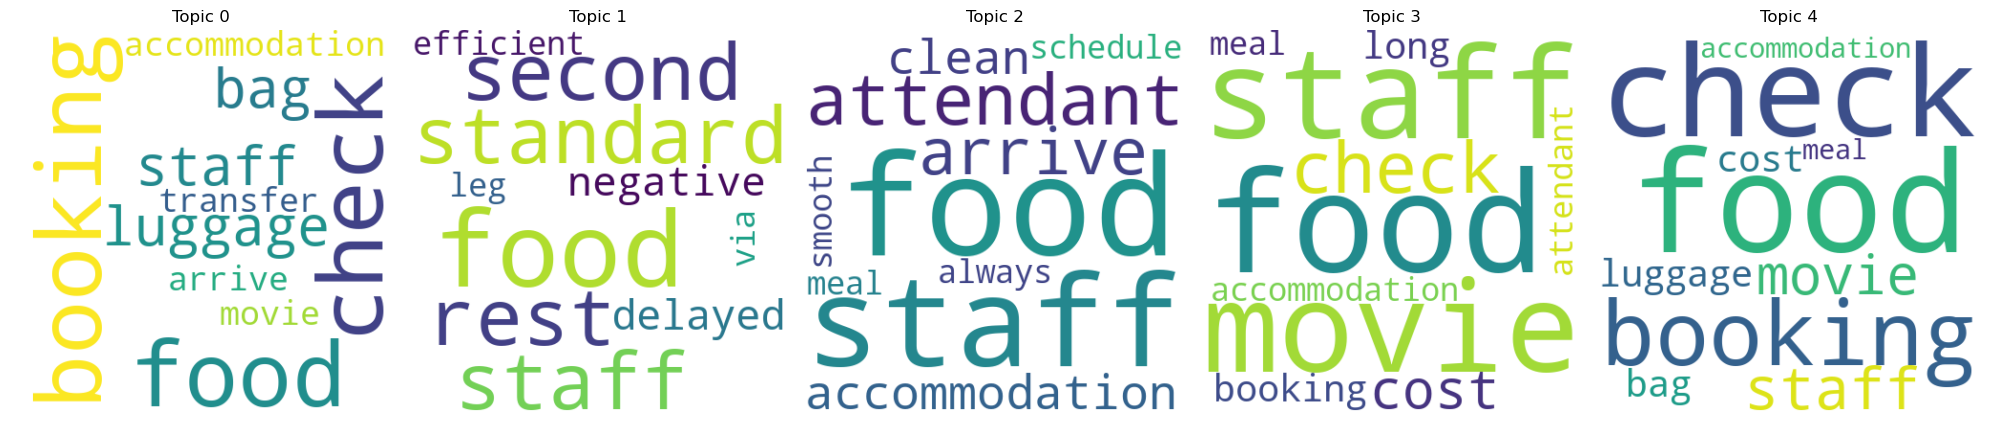

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(1, num_topics, figsize=(20, 5))
for i, ax in enumerate(axes):
    wordcloud = WordCloud(width=400, height=400, background_color="white").generate(
        " ".join(top_words_per_topic[i])
    )
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"Topic {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()


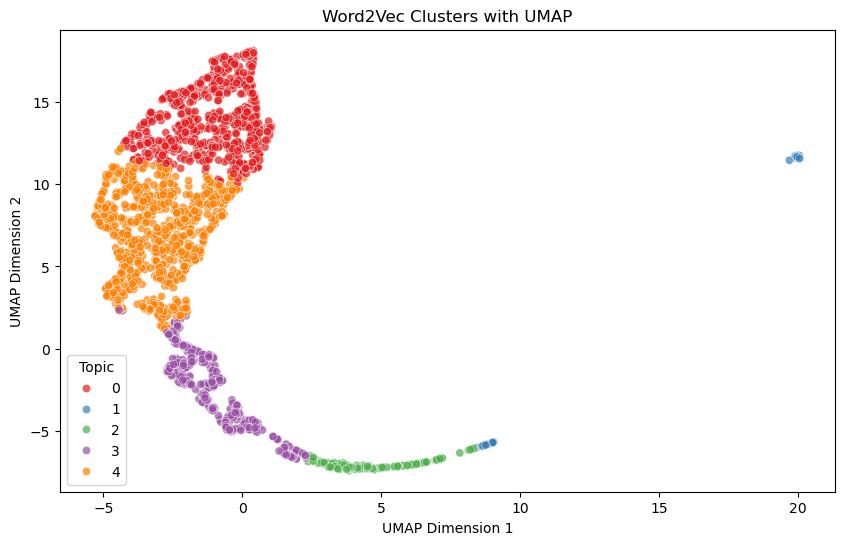

In [29]:
import umap
import seaborn as sns

# Reduce dimensions with UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
word2vec_umap = reducer.fit_transform(vectorized_data["Word2Vec"])

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=word2vec_umap[:, 0],
    y=word2vec_umap[:, 1],
    hue=df_reviews["word2vec_topic"],
    palette="Set1",
    alpha=0.7,
)
plt.title("Word2Vec Clusters with UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Topic")
plt.show()


In [30]:
top_words_per_topic = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [tfidf_feature_names[i] for i in topic.argsort()[-11:-1]]
    top_words_per_topic.append(top_words)

dictionary = Dictionary(df_reviews["lemmatized_text"])
corpus = [dictionary.doc2bow(text) for text in df_reviews["lemmatized_text"]]

coherence_model_nmf = CoherenceModel(
    topics=top_words_per_topic,
    texts=df_reviews["lemmatized_text"],
    dictionary=dictionary,
    coherence="c_v",
)

coherence_nmf = coherence_model_nmf.get_coherence()
print(f"Coherence Score: {coherence_nmf}")

Coherence Score: 0.6320574067892373


In [31]:
coherence_model_nmf_umass = CoherenceModel(
    topics=top_words_per_topic,
    texts=df_reviews["lemmatized_text"],
    dictionary=dictionary,
    coherence="u_mass",
)
coherence_nmf_umass = coherence_model_nmf_umass.get_coherence()
print(f"U_Mass Coherence Score: {coherence_nmf_umass}")

coherence_model_nmf_npmi = CoherenceModel(
    topics=top_words_per_topic,
    texts=df_reviews["lemmatized_text"],
    dictionary=dictionary,
    coherence="c_npmi",
)
coherence_nmf_npmi = coherence_model_nmf_npmi.get_coherence()
print(f"NPMI Coherence Score: {coherence_nmf_npmi}")


U_Mass Coherence Score: -2.4607185988591884
NPMI Coherence Score: 0.05167776841619466


In [32]:
unique_words = set(word for topic in top_words_per_topic for word in topic)
topic_diversity = len(unique_words) / (
    len(top_words_per_topic) * 10
)  # Normalize by top-10 words
print(f"Topic Diversity: {topic_diversity:.4f}")


Topic Diversity: 0.9000


In [33]:
import os

# Define the directory path
save_dir = "../models/kmeans_word2vec"

# Create the directory if it does not exist
os.makedirs(save_dir, exist_ok=True)

# Save KMeans model
save_path = os.path.join(save_dir, "kmeans_word2vec.pkl")
with open(save_path, "wb") as f:
    pickle.dump(kmeans_model, f)

print(f"KMeans Word2Vec model saved successfully at {save_path}")


KMeans Word2Vec model saved successfully at ../models/kmeans_word2vec/kmeans_word2vec.pkl


In [34]:
# Assign Word2Vec cluster labels to DataFrame
df_reviews["word2vec_labels"] = (
    word2vec_topics  # word2vec_topics are the cluster labels from KMeans
)

# Save the original DataFrame with Word2Vec cluster labels to the cluster_analysis folder
df_reviews.to_csv(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/processed/cluster_analysis/reviews_with_word2vec_clusters.csv",
    index=False,
)


In [35]:
from gensim.models import Word2Vec

# Load the Word2Vec model
word2vec_model = Word2Vec.load("../data/interim/word2vec_model.bin")

word_vectors = word2vec_model.wv
top_words_per_cluster = []

for i in range(kmeans_model.n_clusters):
    cluster_words = [
        word
        for word, label in zip(word_vectors.index_to_key, kmeans_model.labels_)
        if label == i
    ]
    top_words_per_cluster.append(cluster_words[:10])

coherence_model_w2v = CoherenceModel(
    topics=top_words_per_cluster,
    texts=df_reviews["lemmatized_text"],
    dictionary=dictionary,
    coherence="c_v",
)

coherence_w2v = coherence_model_w2v.get_coherence()
print(f"Coherence Score: {coherence_w2v}")

Coherence Score: 0.46595457089921455


In [36]:
coherence_model_w2v_umass = CoherenceModel(
    topics=top_words_per_cluster,
    texts=df_reviews["lemmatized_text"],
    dictionary=dictionary,
    coherence="u_mass",
)
coherence_w2v_umass = coherence_model_w2v_umass.get_coherence()
print(f"U_Mass Coherence Score: {coherence_w2v_umass}")

coherence_model_w2v_npmi = CoherenceModel(
    topics=top_words_per_cluster,
    texts=df_reviews["lemmatized_text"],
    dictionary=dictionary,
    coherence="c_npmi",
)
coherence_w2v_npmi = coherence_model_w2v_npmi.get_coherence()
print(f"NPMI Coherence Score: {coherence_w2v_npmi}")


U_Mass Coherence Score: -5.20704684260616
NPMI Coherence Score: -0.1659280880336296


In [37]:
unique_words = set(word for topic in top_words_per_cluster for word in topic)
topic_diversity = len(unique_words) / (
    len(top_words_per_cluster) * 10
)  # Normalized by top-10 words
print(f"Topic Diversity: {topic_diversity:.4f}")


Topic Diversity: 1.0000


In [38]:
from bertopic import BERTopic

In [39]:
with open("../data/interim/bert_vectorized.pkl", "rb") as f:
    bert_embeddings = pickle.load(f)

df_reviews = pd.read_csv("../data/processed/processed_reviews.csv")
# Convert to NumPy array if it's a list
if isinstance(bert_embeddings, list):
    bert_embeddings = np.array(bert_embeddings)

# Now check the shape
print(f"BERT Shape: {bert_embeddings.shape}")
print(df_reviews[["rating", "lemmatized_text"]].head())

BERT Shape: (2560, 768)
   rating                                    lemmatized_text
0       1  ['often', 'last', 'first', 'purchase', 'luggag...
1       1  ['regard', 'booking', 'accommodation', 'regard...
2       1  ['sky', 'sky', 'staff', 'amount', 'without', '...
3       1  ['I', 've', 'always', 'shock', 'first', 'check...
4       1  ['family', 'ruin', 'arrive', 'check', 'counter...


In [40]:
topic_model = BERTopic(
    language="english", calculate_probabilities=True, min_topic_size=10, nr_topics=25
)

topics, probs = topic_model.fit_transform(
    df_reviews["lemmatized_text"], bert_embeddings
)

df_reviews["bert_topic"] = topics


In [41]:
topic_model.get_topic_info().head(10)

Topic  Count                                Name  \
0     -1     18  -1_agent_accommodation_bag_booking   
1      0    318         0_check_booking_luggage_bag   
2      1   2186            1_food_staff_movie_check   
3      2     15   2_via_staff_professional_inflight   
4      3     23   3_smooth_condition_negative_major   

                                      Representation  \
0  [agent, accommodation, bag, booking, queue, ba...   
1  [check, booking, luggage, bag, queue, cost, fi...   
2  [food, staff, movie, check, booking, luggage, ...   
3  [via, staff, professional, inflight, boarding,...   
4  [smooth, condition, negative, major, personal,...   

                                 Representative_Docs  
0  [['transfer', 'love', 'check', 'baggage', 'stu...  
1  [['ever', 'life', 'budget', 'first', 'baggage'...  
2  [['klm', 'movie', 'food', 'complete', 'cramp',...  
3                      [['staff'], ['via'], ['via']]  
4            [['condition'], ['smooth'], ['smooth']]

In [42]:
import plotly.io as pio

In [43]:
# pio.renderers.default = "notebook"

# topic_model.visualize_topics()

In [44]:
topic_model.visualize_barchart(top_n_topics=20)

In [45]:
topic_model.visualize_heatmap()


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Extract top words per topic from BERTopic
topic_info = topic_model.get_topics()
top_words_per_topic = [
    [word for word, _ in topic_info[i]] for i in topic_info.keys() if i != -1
]  # Ignore topic -1

# Convert topics into single strings (for TF-IDF)
topic_strings = [" ".join(words) for words in top_words_per_topic]

# Vectorize topic words using TF-IDF
vectorizer = TfidfVectorizer()
topic_vectors = vectorizer.fit_transform(topic_strings)

# Compute pairwise cosine similarity between topics
topic_coherence_scores = cosine_similarity(topic_vectors)

# Average similarity as coherence score
coherence_score_bert = np.mean(topic_coherence_scores)

print(f"Approximate Coherence Score for BERT Topics: {coherence_score_bert}")


Approximate Coherence Score for BERT Topics: 0.34087501834212874


In [47]:
bert_model_path = "../models/bertopic_model"

# Save the model
topic_model.save(bert_model_path)

2025-03-26 09:06:21,794 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [48]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import pickle

In [49]:
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

In [50]:
df_reviews = pd.read_csv("../data/processed/processed_reviews.csv")

In [51]:
sbert_embeddings = sbert_model.encode(
    df_reviews["lemmatized_text"].tolist(), show_progress_bar=True
)

Batches:   0%|          | 0/80 [00:00<?, ?it/s]

In [52]:
with open("../data/interim/sbert_vectorized.pkl", "wb") as f:
    pickle.dump(sbert_embeddings, f)

In [53]:
print(f"SBERT Embeddings Shape: {sbert_embeddings.shape}")

SBERT Embeddings Shape: (2560, 384)


In [54]:
import umap
import hdbscan

reducer = umap.UMAP(n_components=50, random_state=42)
sbert_reduced = reducer.fit_transform(sbert_embeddings)

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=3, metric="euclidean")
cluster_labels = hdbscan_model.fit_predict(sbert_reduced)

df_reviews["sbert_hdbscan_topic"] = cluster_labels
print(df_reviews["sbert_hdbscan_topic"].value_counts())

sbert_hdbscan_topic
-1     1049
 1      182
 22     165
 9      161
 19     126
 2       84
 12      82
 8       73
 3       59
 18      56
 21      55
 23      53
 11      48
 4       43
 0       42
 16      39
 10      38
 13      27
 20      27
 6       25
 24      23
 14      21
 15      21
 7       21
 17      20
 5       20
Name: count, dtype: int64


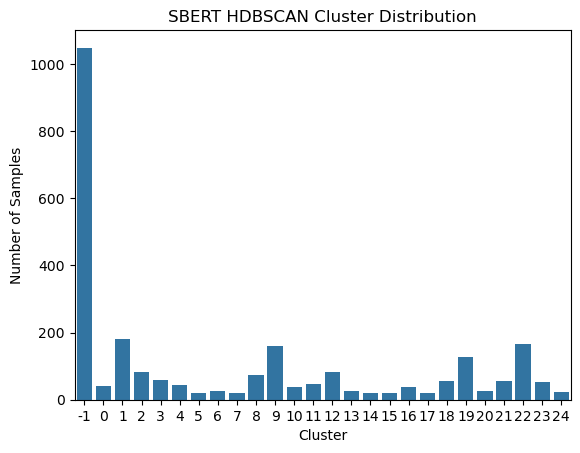

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=cluster_labels)
plt.xlabel("Cluster")
plt.ylabel("Number of Samples")
plt.title("SBERT HDBSCAN Cluster Distribution")
plt.show()


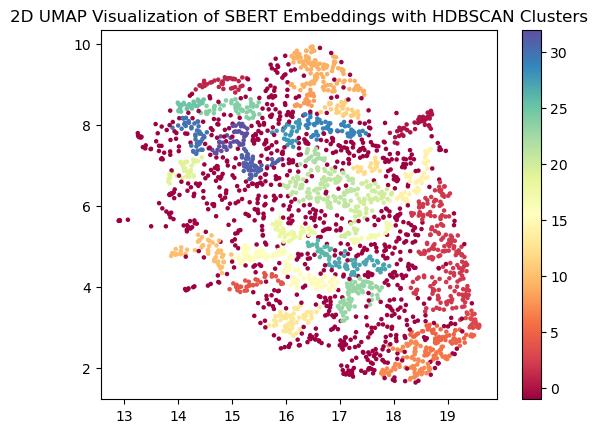

In [56]:
# Reduce dimensions to 2 for visualization
reducer = umap.UMAP(n_components=2, min_dist=0.1, metric="cosine", random_state=42)
sbert_reduced_2d = reducer.fit_transform(sbert_embeddings)

# Apply HDBSCAN clustering
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=3, metric="euclidean")
cluster_labels = hdbscan_model.fit_predict(sbert_reduced_2d)

# Visualize the clusters
import matplotlib.pyplot as plt

plt.scatter(
    sbert_reduced_2d[:, 0],
    sbert_reduced_2d[:, 1],
    c=cluster_labels,
    cmap="Spectral",
    s=5,
)
plt.title("2D UMAP Visualization of SBERT Embeddings with HDBSCAN Clusters")
plt.colorbar()
plt.show()


In [ ]:
with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/models/hdbscan_model.pkl",
    "wb",
) as f:
    pickle.dump(hdbscan_model, f)

In [ ]:
# Add the HDBSCAN cluster labels to the DataFrame
df_reviews["sbert_hdbscan_topic"] = (
    cluster_labels  # Assuming cluster_labels is the result from HDBSCAN
)

# Save the updated DataFrame with HDBSCAN cluster labels to the cluster_analysis folder
df_reviews.to_csv(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/processed/cluster_analysis/reviews_with_hdbscan_clusters.csv",
    index=False,
)

print("DataFrame with HDBSCAN cluster labels saved successfully.")


DataFrame with HDBSCAN cluster labels saved successfully.


In [ ]:
from bertopic import BERTopic

# Fit BERTopic on SBERT embeddings
bertopic_model = BERTopic()
topics, probs = bertopic_model.fit_transform(
    df_reviews["lemmatized_text"].tolist(), sbert_embeddings
)

# Assign topics to DataFrame
df_reviews["sbert_bertopic"] = topics

# Display topic summaries
bertopic_model.get_topic_info()


Topic  Count                                   Name  \
0      -1   1394            -1_food_movie_booking_staff   
1       0    159          0_luggage_bag_baggage_deliver   
2       1    117  1_canceled_booking_compensation_email   
3       2     86        2_transfer_delayed_bus_boarding   
4       3     72         3_attendant_attitude_meal_food   
5       4     69               4_movie_food_watch_clean   
6       5     68          5_queue_check_staff_efficient   
7       6     66            6_wine_food_sandwich_french   
8       7     55             7_wife_extra_husband_chair   
9       8     54             8_check_queue_bag_boarding   
10      9     40              9_lounge_food_board_drink   
11     10     39        10_booking_cost_difference_haul   
12     11     31           11_staff_food_rest_necessary   
13     12     27           12_luggage_baggage_jet_snack   
14     13     24             13_lounge_check_meal_movie   
15     14     24        14_accommodation_leg_staff_food   
16     15     20               15_free_cheap_wine_drink   
17     16     18   16_accommodation_bus_canceled_french   
18     17     18          17_double_negative_always_ill   
19     18     18         18_boarding_board_san_organize   
20     19     18       19_staff_personnel_organize_thru   
21     20     17       20_cost_food_attention_expensive   
22     21     14       21_british_far_inflight_platinum   
23     22     13         22_deck_upper_storage_beverage   
24     23     12     23_restroom_toilet_section_private   
25     24     12             24_stroller_infant_son_kid   
26     25     12       25_inflight_landing_movie_mostly   
27     26     12      26_croissant_tea_breakfast_custom   
28     27     11     27_inflight_movie_beverage_present   
29     28     10          28_chair_wheel_boarding_thank   
30     29     10            29_staff_sorry_member_drink   
31     30     10          30_breakfast_light_roll_board   
32     31     10              31_love_food_thank_always   

                                       Representation  \
0   [food, movie, booking, staff, check, cost, mea...   
1   [luggage, bag, baggage, deliver, arrive, suitc...   
2   [canceled, booking, compensation, email, money...   
3   [transfer, delayed, bus, boarding, miss, arriv...   
4   [attendant, attitude, meal, food, drink, movie...   
5   [movie, food, watch, clean, narrow, video, mus...   
6   [queue, check, staff, efficient, board, chaoti...   
7   [wine, food, sandwich, french, snack, cold, de...   
8   [wife, extra, husband, chair, food, attendant,...   
9   [check, queue, bag, boarding, luggage, print, ...   
10  [lounge, food, board, drink, united, wine, bar...   
11  [booking, cost, difference, haul, directly, ac...   
12  [staff, food, rest, necessary, water, attentio...   
13  [luggage, baggage, jet, snack, smooth, arrive,...   
14  [lounge, check, meal, movie, aisle, toilet, pr...   
15  [accommodation, leg, staff, food, accommodate,...   
16  [free, cheap, wine, drink, champagne, meal, cr...   
17  [accommodation, bus, canceled, french, eventua...   
18  [double, negative, always, ill, future, standa...   
19  [boarding, board, san, organize, traffic, dela...   
20  [staff, personnel, organize, thru, european, a...   
21  [cost, food, attention, expensive, difference,...   
22  [british, far, inflight, platinum, airways, pi...   
23  [deck, upper, storage, beverage, window, sligh...   
24  [restroom, toilet, section, private, water, fr...   
25  [stroller, infant, son, kid, pet, baby, child,...   
26  [inflight, landing, movie, mostly, smooth, jet...   
27  [croissant, tea, breakfast, custom, coffee, dr...   
28  [inflight, movie, beverage, present, food, air...   
29  [chair, wheel, boarding, thank, responsibility...   
30  [staff, sorry, member, drink, min, head, arran...   
31  [breakfast, light, roll, board, lunch, sleep, ...   
32  [love, food, thank, always, clean, care, sleep...   

                                  Representative_Docs  
0 

In [ ]:
# Add the BERTopic cluster labels to DataFrame
df_reviews["sbert_bertopic_labels"] = (
    topics  # 'topics' is the list of topics generated by BERTopic
)

# Save the updated DataFrame with BERTopic cluster labels to the cluster_analysis folder
df_reviews.to_csv(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/processed/cluster_analysis/reviews_with_bertopic_clusters.csv",
    index=False,
)

print("DataFrame with BERTopic clusters saved successfully.")


DataFrame with BERTopic clusters saved successfully.


In [ ]:
from collections import Counter

# Filter reviews that belong to topic -1
noise_reviews = df_reviews[df_reviews["sbert_bertopic"] == -1]["lemmatized_text"]

# Convert from string to list if needed
noise_reviews = noise_reviews.apply(eval)  # Only if stored as stringified lists

# Flatten all words from noisy reviews
all_noise_words = [word for review in noise_reviews for word in review]

# Count the most common words
top_noise_words = Counter(all_noise_words).most_common(400)  # Get top 20 words

# Display results
print("Top words in Noise (-1) Cluster:")
for word, count in top_noise_words:
    print(f"{word}: {count}")


Top words in Noise (-1) Cluster:
food: 658
booking: 526
check: 475
staff: 396
movie: 395
cost: 299
accommodation: 297
luggage: 270
first: 261
long: 261
meal: 255
arrive: 233
delayed: 232
leg: 201
transfer: 198
people: 185
board: 171
drink: 169
boarding: 168
bag: 165
attendant: 154
always: 153
queue: 152
last: 148
ever: 147
extra: 144
baggage: 137
compensation: 132
due: 118
french: 117
miss: 117
sit: 116
sleep: 113
klm: 111
without: 110
snack: 104
canceled: 100
clean: 98
able: 94
home: 94
ve: 93
speak: 92
wine: 91
lounge: 91
front: 88
money: 87
free: 87
later: 85
agent: 85
end: 84
land: 84
wife: 80
although: 80
via: 79
person: 78
different: 77
number: 74
s: 71
care: 71
I: 71
average: 71
inflight: 67
less: 66
far: 65
professional: 65
smooth: 65
dinner: 62
least: 62
water: 61
email: 60
haul: 59
window: 59
second: 58
flat: 58
schedule: 58
treat: 58
phone: 57
family: 56
partner: 56
english: 55
desk: 55
everyone: 54
rest: 54
breakfast: 54
especially: 53
anything: 53
ground: 53
half: 52
stand

In [ ]:
# Get c-TF-IDF scores per topic
ctfidf_scores = bertopic_model.get_topic_info()

# Display the extracted topic words and their importance scores
import pandas as pd

print(pd.DataFrame(ctfidf_scores))


    Topic  Count                                   Name  \
0      -1   1394            -1_food_movie_booking_staff   
1       0    159          0_luggage_bag_baggage_deliver   
2       1    117  1_canceled_booking_compensation_email   
3       2     86        2_transfer_delayed_bus_boarding   
4       3     72         3_attendant_attitude_meal_food   
5       4     69               4_movie_food_watch_clean   
6       5     68          5_queue_check_staff_efficient   
7       6     66            6_wine_food_sandwich_french   
8       7     55             7_wife_extra_husband_chair   
9       8     54             8_check_queue_bag_boarding   
10      9     40              9_lounge_food_board_drink   
11     10     39        10_booking_cost_difference_haul   
12     11     31           11_staff_food_rest_necessary   
13     12     27           12_luggage_baggage_jet_snack   
14     13     24             13_lounge_check_meal_movie   
15     14     24        14_accommodation_leg_staff_food 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Get c-TF-IDF matrix from BERTopic
ctfidf_matrix = bertopic_model.c_tf_idf_

# Compute cosine similarity between topics
topic_similarities = cosine_similarity(ctfidf_matrix)

# Compute mean similarity (higher is better)
coherence_score = np.mean(topic_similarities)
print(f"SBERT Coherence Score (Cosine Similarity): {coherence_score:.4f}")


SBERT Coherence Score (Cosine Similarity): 0.2307


In [ ]:
# Save the SBERT BERTopic model
bertopic_model.save("../models/sbert_bertopic_model", save_embedding_model=True)

print("SBERT BERTopic model saved successfully!")


2025-03-24 14:10:49,353 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


SBERT BERTopic model saved successfully!


In [ ]:
df_reviews.to_csv("../data/processed/sbert_bertopic_reviews.csv", index=False)
print("SBERT topic assignments saved successfully!")


SBERT topic assignments saved successfully!
